In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import torch
import torch_geometric as pyg
import torch.nn.functional as F

In [25]:
ska_data_file = "/workspaces/masters_project/data/ska/raw_dataset.txt"
#load the file into a numpy array
df = pd.read_csv(ska_data_file, sep=" ", header=None)
#convert the pandas dataframe to a numpy array
data = df.to_numpy()


In [26]:
#create a square matrix corresponding to the number of nodes and fill it with the euclidean distance between each point. 
#the last two element of each row is the x and y coordinate of the point
n = len(data)
dist_matrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        x_i, y_i = data[i][-2], data[i][-1]
        x_j, y_j = data[j][-2], data[j][-1]
        euclidean_distance = (x_i - x_j)**2 + (y_i - y_j)**2
        euclidean_distance = euclidean_distance**0.5
        dist_matrix[i][j] = euclidean_distance
dist_matrix = torch.tensor(dist_matrix)

In [27]:
dist_matrix.shape
graph = torch.load("/workspaces/masters_project/data/graph_dataset.pt")
graph


Data(x=[512], edge_index=[2, 130816], pos=[512, 2], edge_attr=[130816, 1])

In [28]:
graph.x.shape

torch.Size([512])

In [29]:
dist_matrix

tensor([[0.0000, 0.0033, 0.0011,  ..., 0.3451, 0.3455, 0.3455],
        [0.0033, 0.0000, 0.0022,  ..., 0.3421, 0.3424, 0.3425],
        [0.0011, 0.0022, 0.0000,  ..., 0.3440, 0.3443, 0.3444],
        ...,
        [0.3451, 0.3421, 0.3440,  ..., 0.0000, 0.0009, 0.0006],
        [0.3455, 0.3424, 0.3443,  ..., 0.0009, 0.0000, 0.0005],
        [0.3455, 0.3425, 0.3444,  ..., 0.0006, 0.0005, 0.0000]],
       dtype=torch.float64)

In [30]:
from sklearn.cluster import SpectralClustering, spectral_clustering

In [31]:
def k_means(data, num_clusters, max_iters=100):
    """For data we'll use eigenvalues of the Laplacian of a graph"""
    centroids = data[:num_clusters, :]
    for _ in range(max_iters):
        distances = torch.cdist(data, centroids, p=2)
        cluster_assignments = torch.argmin(distances, dim=1)
        new_centroids = torch.stack([data[cluster_assignments == i].mean(0) for i in range(num_clusters)])
        if torch.equal(new_centroids, centroids):
            break
        centroids = new_centroids
        
    return centroids, cluster_assignments
def spectral_clustering_labeebs(adjacency_matrix, num_clusters=2):
    # Laplacian:
    degree_matrix = torch.diag(torch.sum(adjacency_matrix, dim=1))
    laplacian_matrix = degree_matrix - adjacency_matrix

    # Eigenvalue Decomposition
    eigenvalues, eigenvectors = torch.linalg.eigh(laplacian_matrix)
    eigenvectors = eigenvectors[:, 1:num_clusters+1]  # Use the first num_clusters eigenvectors
    eigenvectors = F.normalize(eigenvectors, p=2, dim=1)

    # K-Means for clustering
    centroids, cluster_assignments = k_means(eigenvectors, num_clusters)

    return cluster_assignments

In [32]:

def extract_edges(data, node_id):
    """
    Extracts the edges from a graph and returns a list of edges
    """
    #get the edges
    subset = torch.tensor(node_id)
    
    edge_index, edge_attr  = pyg.utils.subgraph(subset=torch.tensor(node_id),
                                                 edge_index=data.edge_index, edge_attr=data.edge_attr)
    subg_data = data.x[torch.tensor(node_id)]
    subgraph = pyg.data.Data(x = subg_data , edge_index=edge_index, edge_attr=edge_attr)

    return subgraph



In [33]:
# cluster_classification = spectral_clustering(dist_matrix,
#                                               n_clusters=2, assign_labels="cluster_qr", random_state=0)
cluster_classifcation = spectral_clustering_labeebs(dist_matrix, num_clusters=2)

#nodes in cluster 1
cluster_1 = np.where(cluster_classifcation == 0)[0]
#nodes in cluster 2
cluster_2 = np.where(cluster_classifcation == 1)[0]


subgraph_1 = extract_edges(graph, cluster_1)
subgraph_2 = extract_edges(graph, cluster_2)
edges_length_1 = subgraph_1.edge_attr.numpy()
edges_length_2 = subgraph_2.edge_attr.numpy()


In [34]:
cluster_classifcation

tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [35]:
cluster_1.shape, cluster_2.shape

((186,), (326,))

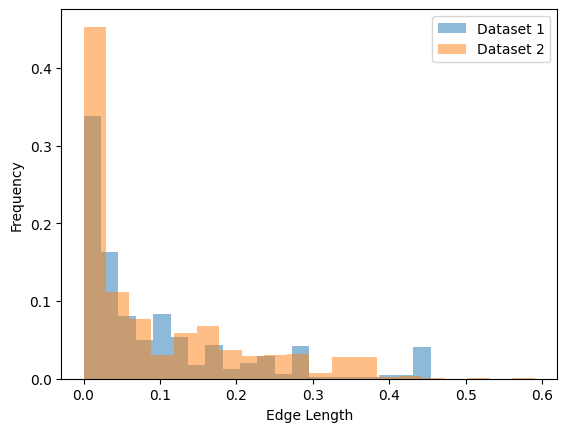

In [36]:
#plot the two edges
hist1, bins1 = np.histogram(edges_length_1, bins=20, density=True)
hist2, bins2 = np.histogram(edges_length_2, bins=20, density=True)

# Normalize the histograms
hist1 /= hist1.sum()
hist2 /= hist2.sum()

# Calculate the bin centers
bin_centers1 = (bins1[:-1] + bins1[1:]) / 2
bin_centers2 = (bins2[:-1] + bins2[1:]) / 2

# Plot the normalized histograms
plt.bar(bin_centers1, hist1, width=(bin_centers1[1] - bin_centers1[0]), alpha=0.5, label='Dataset 1')
plt.bar(bin_centers2, hist2, width=(bin_centers2[1] - bin_centers2[0]), alpha=0.5, label='Dataset 2')
plt.xlabel("Edge Length")
plt.ylabel("Frequency")

plt.legend(loc='upper right')


Training a ML model for it

First thing: Use the adjancey matrix + the x values of the graph to come up with something

In [37]:
def multiply_adj(x_val, adjaceny_matrix):
    """
    x_val goes from [0, 512] for the 512 nodes in the graph
    adjaceny_matrix is the adjacency matrix of the graph
    we want to multiply each element of ajacney matrix by x_val. 
    for two of them we do x_val_i * x_val_j * adjaceny_matrix[i][j]
    """
    #get the number of nodes
    n = len(adjaceny_matrix)
    #create a matrix of zeros
    new_matrix = np.zeros((n,n))
    #loop through the matrix and multiply each element by x_val
    for i in range(n):
        for j in range(n):
            new_matrix[i][j] = x_val[i] * x_val[j] * adjaceny_matrix[i][j]
    return new_matrix

Now we can pass this as input to the Spectral Classification

In [38]:
multiply_adj_matrix = multiply_adj(graph.x, dist_matrix.numpy())

In [39]:
multiply_adj_matrix.shape

(512, 512)

In [40]:
#now get clustering for this matrix
cluster_classification = spectral_clustering_labeebs(torch.tensor(multiply_adj_matrix), num_clusters=2)


In [41]:
class SpectralClusteringClass(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, num_clusters=2,
                dist_matrix=dist_matrix):
        ctx.num_clusters = 2
        multiply_adj_matrix = multiply_adj(input, dist_matrix.numpy())
        return spectral_clustering_labeebs(multiply_adj_matrix, num_clusters=2)

    @staticmethod
    def backward(ctx, grad_output):
  
        return grad_output, None, None

In [42]:
class GradApproxGraph(torch.autograd.Function):
    def __init__(self, model, input_data, lambda_val=20,
                 example_input=None):
        """
        input_data here is a graph with the correct edges. and setup.
        Doing this will let us pass the model through the graph itself.
        """
        self.input_data = input_data # graph
        self.input = None
        self.output = None
        self.prev_input = example_input
        self.curr_output = None
        self.lambda_val = lambda_val
        self.model = model
        
    @staticmethod
    def forward(ctx, combinatorial_solver_output, x, graph_obj):
        """
        Combinatorial solver output is [num_nodes, 1]
        gnn_output is [num_nodes, 1]

        """
        ctx.save_for_backward(combinatorial_solver_output, x) 
        ctx.graph = graph_obj # save_for_backward doesn't work for non-tensors
        
        return combinatorial_solver_output


    @staticmethod
    def backward(ctx, grad_input):
        lambda_val = 20
        combinatorial_solver_output, x = ctx.saved_tensors
        graph = ctx.graph

        perturbed_gnn_weights = x + torch.multiply(lambda_val, grad_input)
        perturbed_gnn_output = SpectralClusteringClass.apply(perturbed_gnn_weights, graph)
        new_grads = - (1 / lambda_val) * (combinatorial_solver_output - perturbed_gnn_output)
        import copy
        new_grads_2 = copy.deepcopy(new_grads)
        new_grads_2.requires_grad_(True).unsqueeze_(-1)
        
        return new_grads, new_grads_2, None

In [44]:
from torch_geometric.nn import GCNConv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class WarCraftModel(torch.nn.Module):
    def __init__(self, cfg, ):
        super(WarCraftModel, self).__init__()
        self.cfg = cfg
        self.conv1 = GCNConv(1, 32)
        self.conv2 = GCNConv(32, 32)
        self.conv3 = GCNConv(32, 1)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.bn2 = torch.nn.BatchNorm1d(32)
        self.bn3 = torch.nn.BatchNorm1d(32)

        self.combinatorial_solver = SpectralClusteringClass.apply
        self.grad_approx = GradApproxGraph.apply

    def forward(self, data, embedding_output=False,
                additional_feat=True):
        x, edge_index, edge_attr = data.mean_color, data.edge_index, data.edge_attr
        edge_index = edge_index.to(torch.long).to(device)
        edge_attr = edge_attr.to(torch.float).to(device)
        x = x.to(torch.float).to(device)
        #import pdb; pdb.set_trace()
        x = self.conv1(x, edge_index, edge_attr.float())
        x = self.bn1(x)
        x = torch.nn.ReLU()(x)
        x = self.conv2(x, edge_index, edge_attr.float())
        x = self.bn2(x)
        x = torch.nn.ReLU()(x)
        x = self.conv3(x, edge_index, edge_attr.float())
        #x = global_max_pool(x, data.batch) # This might not work (issues with shape?)
        #gradients have issues here. 
        #x.shape here is [123, 1]. so maybe we unsqueeze here

        combinatorial_solver_output = self.combinatorial_solver(x, data)
        x = self.grad_approx(combinatorial_solver_output, x, data)

        return x 


In [46]:
model = WarCraftModel(None)
model = model.to(device)

Lets get some Loss

Loss will be the "clustering" approximator and then we use this 

In [47]:
cluster_1 = np.where(cluster_classifcation == 0)[0]
#nodes in cluster 2
cluster_2 = np.where(cluster_classifcation == 1)[0]


subgraph_1 = extract_edges(graph, cluster_1)
subgraph_2 = extract_edges(graph, cluster_2)
edges_length_1 = subgraph_1.edge_attr.numpy()
edges_length_2 = subgraph_2.edge_attr.numpy()


In [50]:
edges_length_1.shape  #these two are both generated by the same graph
edges_length_2.shape

(52975, 1)

Problem now is to get a differentiable form of getting classification to meaningful edges.
shape of classifcation = [n, 1] 
then we get a mask of "edges".
then we get a histogram of edges etc


In [51]:
dist_1 = torch.histogram(edges_length_1, bins=20, density=True)
dist_2 = torch.histogram(edges_length_2, bins=20, density=True)


TypeError: histogram() received an invalid combination of arguments - got (numpy.ndarray, density=bool, bins=int), but expected one of:
 * (Tensor input, Tensor bins, *, Tensor weight, bool density, tuple of Tensors out)
 * (Tensor input, int bins, *, tuple of floats range, Tensor weight, bool density, tuple of Tensors out)
